In [1]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
import gym
import matplotlib.pyplot as plt
import os
import time
import pickle


!export TF_CPP_MIN_LOG_LEVEL=3

2024-12-20 13:34:44.089300: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 13:34:44.094585: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 13:34:44.108320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734701684.129536   21580 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734701684.135801   21580 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 13:34:44.158018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
LEARNING_RATE = 0.001
GAMMA = 0.99
EPISODES = 5000
BATCH_SIZE = 64
MEMORY_SIZE = 10000
UPDATE_FREQUENCY = 100
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
#reward_threshold = 100
#convergence_window = 50

In [3]:
env = gym.make('CartPole-v1')

In [4]:
class QNetwork(tf.keras.Model):
    def __init__(self, action_space):
        super(QNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(24, activation='relu')
        self.dense2 = tf.keras.layers.Dense(24, activation='relu')
        self.out = tf.keras.layers.Dense(action_space, activation='linear')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

def epsilon_greedy_policy(state, epsilon, model, action_space):
    if random.random() < epsilon:
        return random.choice(range(action_space))
    else:
        state = np.expand_dims(state, axis=0)
        q_values = model(state)
        return np.argmax(q_values.numpy())

In [6]:
def train_dqn(model, target_model, memory, batch_size, gamma, optimizer):
    if memory.size() < batch_size:
        return

    batch = memory.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = np.array(states)
    next_states = np.array(next_states)

    with tf.GradientTape() as tape:
        q_values = model(states)
        next_q_values = target_model(next_states)
        
        target_q_values = q_values.numpy()
        for i in range(batch_size):
            if dones[i]:
                target_q_values[i][actions[i]] = rewards[i]
            else:
                target_q_values[i][actions[i]] = rewards[i] + gamma * np.max(next_q_values[i])

        target_q_values = tf.convert_to_tensor(target_q_values, dtype=tf.float32)
        loss = tf.reduce_mean(tf.square(q_values - target_q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [7]:
action_space = env.action_space.n
model = QNetwork(action_space)
target_model = QNetwork(action_space)
target_model.set_weights(model.get_weights())

In [8]:
replay_buffer = ReplayBuffer(MEMORY_SIZE)

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

2024-12-20 13:34:59.123361: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
reward_list = []

if os.path.exists('reward_list.pkl'):
    with open('reward_list.pkl', 'rb') as f:
        reward_list = pickle.load(f)
        print(f"Loaded reward list with {len(reward_list)} episodes.")
        
start_time = time.time()

for episode in range(len(reward_list), EPISODES):
    episode_start_time = time.time()
    state = env.reset()[0]
    total_reward = 0
    done = False

    while not done:
        action = epsilon_greedy_policy(state, epsilon, model, action_space)
        next_state, reward, done, _, _ = env.step(action)

        replay_buffer.add((state, action, reward, next_state, done))
        
        state = next_state
        total_reward += reward

        train_dqn(model, target_model, replay_buffer, BATCH_SIZE, GAMMA, optimizer)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % UPDATE_FREQUENCY == 0:
        target_model.set_weights(model.get_weights())

    reward_list.append(total_reward)
    with open('reward_list.pkl', 'wb') as f:
        pickle.dump(reward_list, f)

    if episode % 10 == 0:
        episode_end_time = time.time()
        elapsed_time = episode_end_time - episode_start_time
        print(f"Episode {episode}, Total Reward: {total_reward}, Time: {elapsed_time:.2f} seconds")

        
    #if episode >= convergence_window and np.mean(reward_list[-convergence_window:]) >= reward_threshold:
    #    print(f"Converged at episode {episode}, Average Reward: {np.mean(reward_list[-convergence_window:]):.2f}")
    #    break

        
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Total Reward: 13.0, Time: 0.00 seconds
Episode 10, Total Reward: 15.0, Time: 0.64 seconds
Episode 20, Total Reward: 11.0, Time: 0.46 seconds
Episode 30, Total Reward: 14.0, Time: 0.59 seconds
Episode 40, Total Reward: 10.0, Time: 0.42 seconds
Episode 50, Total Reward: 13.0, Time: 0.56 seconds
Episode 60, Total Reward: 13.0, Time: 0.55 seconds
Episode 70, Total Reward: 11.0, Time: 0.46 seconds
Episode 80, Total Reward: 9.0, Time: 0.38 seconds
Episode 90, Total Reward: 24.0, Time: 0.99 seconds
Episode 100, Total Reward: 13.0, Time: 0.56 seconds
Episode 110, Total Reward: 19.0, Time: 0.81 seconds
Episode 120, Total Reward: 12.0, Time: 0.51 seconds
Episode 130, Total Reward: 27.0, Time: 1.15 seconds
Episode 140, Total Reward: 10.0, Time: 0.44 seconds
Episode 150, Total Reward: 11.0, Time: 0.47 seconds
Episode 160, Total Reward: 17.0, Time: 0.75 seconds
Episode 170, Total Reward: 11.0, Time: 0.47 seconds
Episode 180, Total Reward: 22.0, Time: 0.94 seconds
Episode 190, Total Rewar

Loaded reward list with 622 episodes.


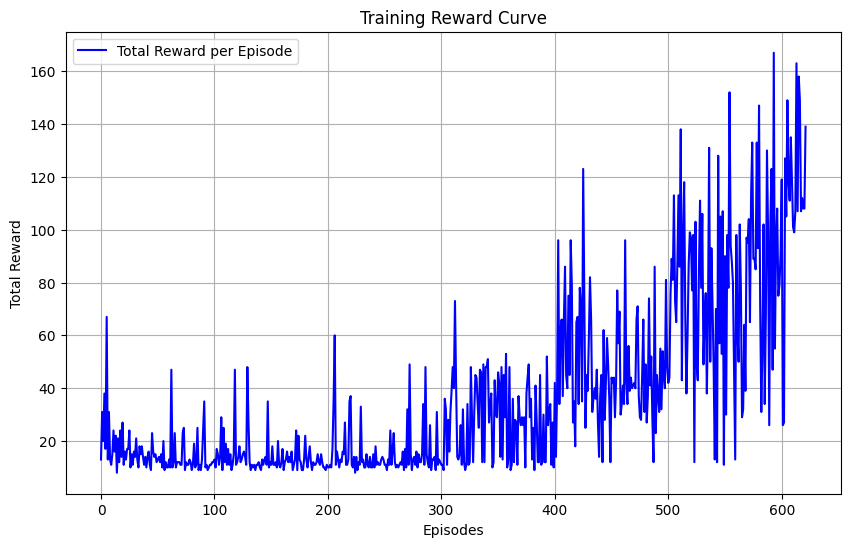

In [11]:
saved_reward_list = []
if os.path.exists('reward_list.pkl'):
    with open('reward_list.pkl', 'rb') as f:
        saved_reward_list = pickle.load(f)
        print(f"Loaded reward list with {len(saved_reward_list)} episodes.")

full_reward_list = saved_reward_list# + reward_list[len(saved_reward_list):]

plt.figure(figsize=(10, 6))
plt.plot(full_reward_list, label='Total Reward per Episode', color='blue')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training Reward Curve')
plt.legend()
plt.grid(True)
plt.show()